<h2 style="color:blue" align="center">Insurance Price Prediction</h2>

#### Import the necessary libraries

In [165]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random as python_random
import time, math 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler 

from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout
from keras.callbacks import Callback, CSVLogger, EarlyStopping    

import warnings
warnings.filterwarnings('ignore')

#### Reserve GPU memory for the execution

In [166]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

#### Load the dataset

In [167]:
df = pd.read_csv('insurance.csv')
df.shape

(1338, 7)

In [168]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [169]:
# one-hot encode the dataframe
df1 = df[['sex','smoker','region']]
df1 = pd.get_dummies(df1)
df1.head()

,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,1,0,0,1,0,0,0,1
1,0,1,1,0,0,0,1,0
2,0,1,1,0,0,0,1,0
3,0,1,1,0,0,1,0,0
4,0,1,1,0,0,1,0,0


In [170]:
# Normalization
df2 = df[['age','bmi','children']]
mms = MinMaxScaler()
mms.fit(df2)
df2_normalized = mms.transform(df2) 
df2 = pd.DataFrame(df2_normalized,columns=['age','bmi','children'])
df2.head()

,age,bmi,children
0,0.021739,0.321227,0.0
1,0.000000,0.479150,0.2
2,0.217391,0.458434,0.6
3,0.326087,0.181464,0.0
4,0.304348,0.347592,0.0


In [171]:
X = pd.concat([df2,df1],axis=1)
X.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.021739,0.321227,0.0,1,0,0,1,0,0,0,1
1,0.000000,0.479150,0.2,0,1,1,0,0,0,1,0
2,0.217391,0.458434,0.6,0,1,1,0,0,0,1,0
3,0.326087,0.181464,0.0,0,1,1,0,0,1,0,0
4,0.304348,0.347592,0.0,0,1,1,0,0,1,0,0


In [172]:
Y = df[["charges"]]
Y.head()

,charges
0,16884.92400
1,1725.55230
2,4449.46200
3,21984.47061
4,3866.85520


#### Split the dataset into training and testing set

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0) 

In [174]:
X_train.shape

(1070, 11)

#### Define DNN model

In [181]:
python_random.seed(7)
np.random.seed(7)
tf.random.set_seed(7)
opti_name = ''

def get_model(): 
    tf.keras.backend.clear_session()
    model = Sequential([ 
        Dense(1024, input_dim = 11), 
        LeakyReLU(),
        BatchNormalization(),
        Dropout(0.4),
    
        Dense(512),  
        LeakyReLU(),
        BatchNormalization(),
        Dropout(0.3),

        Dense(512),  
        LeakyReLU(),
        BatchNormalization(),
        Dropout(0.3),
    
        Dense(units=256), 
        LeakyReLU(),
        BatchNormalization(),
        Dropout(0.2),
    
        Dense(units=256), 
        LeakyReLU(),
        BatchNormalization(),
        Dropout(0.01), 
    
        Dense(units=128),
        LeakyReLU(), 
        Dropout(0.05),
        Dense(units=1, activation="linear"),
    ], name = "DNN_model")
    
    global opti_name
    
    # General SGD
    #opti = keras.optimizers.SGD(learning_rate=0.001)
    #opti_name = 'SGD'
    
    # SGD with momentum
    #opti = keras.optimizers.SGD(learning_rate=0.001, momentum=0.4)
    #opti_name = 'SGD with momentum'
    
    # SGD with Nesterov momentum 
    #opti = keras.optimizers.SGD(learning_rate=0.001, momentum=0.4, nesterov=True)
    #opti_name = 'SGD with Nesterov momentum'
    
    # RMSprop 
    #opti = keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.4)
    #opti_name = 'RMSprop'
    
    # Adam
    opti = keras.optimizers.Adam(learning_rate=0.001) 
    opti_name = 'Adam'
    
    # Adamax
    #opti = keras.optimizers.Adamax(learning_rate=0.001) 
    #opti_name = 'Adamax'
    
    # Nadam
    #opti = keras.optimizers.Nadam(learning_rate=0.001) 
    #opti_name = 'Nadam'  

    
    model.compile(
        optimizer = opti,
        loss = 'mean_squared_error',
        metrics = ['mae']
    )
    
    return model

#### Custom callbacks

For generic optimizer model

In [182]:
# Get the best of base-line model and set it as stopping criteria in HM-based model
generic_best = 0

class CustomCallbackGeneric(Callback):  
    def on_epoch_end(self, epoch, logs={}): 
        global generic_best
        error = round(logs.get('mae'), 4) 
        
        if epoch == 0:
            generic_best = error     
        
        if epoch > 0 and error < generic_best :
            generic_best = error

For HM based optimizer model

In [183]:
class CustomCallbackHM(Callback):  
    initial_weights = 0
    previous_weights = 0
    call_hm = 0  
     
    def on_train_begin(self, logs=None):
        self.initial_weights = model_hm.get_weights() 
        self.initial_weights = np.array(self.initial_weights,dtype=object)
        self.previous_weights = self.initial_weights
        # Harmonic mean based weights calculation
        self.call_hm = np.vectorize(self.apply_hm)  
             
    def on_epoch_end(self, epoch, logs={}):  
        # Set the stopping criteria at (stop_at) the MAE obtained from the baseline model 
        global generic_best 
        
        num_layers = len(model_hm.layers)  
        current_weights = model_hm.get_weights()
        current_weights = np.array(current_weights,dtype=object)        

        for i in range(num_layers):  
            # Harmonic mean based weights calculation
            tensor1 = tf.convert_to_tensor(self.previous_weights[i])
            tensor2 = tf.convert_to_tensor(current_weights[i])
            current_weights[i] = self.call_hm(tensor1, tensor2, epoch)   
            
        # Updating the model with new weights
        model_hm.set_weights(current_weights.tolist())
        self.previous_weights = current_weights
        
        #Stopping criteria
        #if(round(logs.get('mae'), 4) < generic_best):  
            #self.model.stop_training = True
        
    def apply_hm(self, v1, v2, epoch):  
        r = 0
        if epoch < 100:
             r = 1
        elif epoch > 100 and epoch < 200:
             r = 0.85
        elif epoch > 200 and epoch < 300:
             r = 0.75
        else:  
             r = 0.65 
            
        if v1==0 or v2==0:
            return v2
        elif v1 > v2:
            t1 = abs(v1)
            t2 = abs(v2)
            hm = 2*t1*t2/(t1+t2)
            min1 = min(t1,t2)
            diff = abs(hm-min1)*r  
            v2 = v2 - diff
            return v2  
        elif v1 < v2:
            t1 = abs(v1)
            t2 = abs(v2)
            hm = 2*t1*t2/(t1+t2)
            min1 = min(t1,t2)
            diff = abs(hm-min1)*r
            v2 = v2 + diff
            return v2   
        else:
            return v2   

#### Training

Get a model to assign same weights to model with and without HM

In [184]:
model = get_model() 
weights = model.get_weights() 
num_epochs = 500
batch_size = 256

To record loss and accuracy in CSV file

In [185]:
generic_file = '4.Insurance '+ opti_name +' optimizer.csv'
hm_file = '4.Insurance '+ opti_name +' HM-based optimizer.csv' 
logger_generic_model = CSVLogger(generic_file, append = False, separator=',')
logger_hm_model = CSVLogger(hm_file, append = False, separator=',')

Generic opimizer model

In [186]:
model_wihtout_hm = get_model()
model_wihtout_hm.set_weights(weights) 
st = time.time() 
model_wihtout_hm.fit(X_train, y_train, epochs = num_epochs, verbose=0, callbacks=[CustomCallbackGeneric(), logger_generic_model], batch_size=batch_size) 
et = time.time()
elapsed_training_time_generic = round(et - st, 4)
print('Execution time:', elapsed_training_time_generic, 'seconds') 

Execution time: 33.7451 seconds


HM based optimizer model

In [187]:
model_hm = get_model()
model_hm.set_weights(weights) 
st = time.time()
model_hm.fit(X_train, y_train, epochs = num_epochs, verbose=0, callbacks=[CustomCallbackHM(),logger_hm_model], batch_size=batch_size) 
et = time.time()
elapsed_training_time_hm = round(et - st, 4)
print('Execution time:', elapsed_training_time_hm, 'seconds') 

Execution time: 198.1739 seconds


Model summary

In [188]:
model_hm.summary()

Model: "DNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              12288     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                         

#### Generic optimizer vs HM-based optimizer

In [189]:
df1 = pd.read_csv(generic_file)
df2 = pd.read_csv(hm_file)

Loss

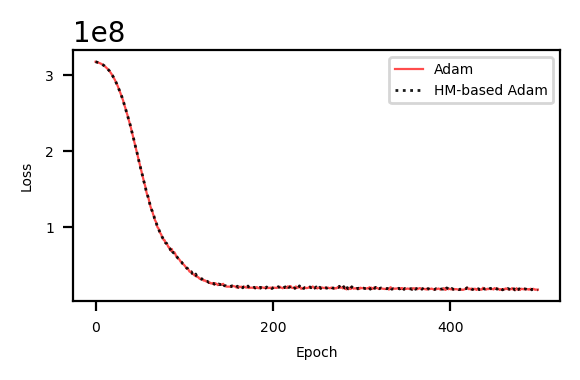

In [197]:
x1 = range(0, df1.shape[0])
x2 = range(0, df2.shape[0])
y1 = df1['loss'] 
y2 = df2['loss']  
plt.figure(figsize = (3,2), dpi = 200)
plt.plot(x1, y1, "r-", label = opti_name, linewidth = 0.8, alpha = 0.7)
plt.plot(x2, y2, "k:", label = 'HM-based ' + opti_name, linewidth = 1, alpha = 0.9) 
plt.ylabel('Loss' , fontdict = {'fontsize':5})
plt.xlabel('Epoch', fontdict = {'fontsize':5}) 
#plt.yscale('log')
#plt.title("Loss", fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xticks(fontsize = 5)
plt.yticks(fontsize = 5)
plt.tight_layout()
plt.legend(prop={'size': 5})
#plt.savefig("graph.png",bbox_inches='tight',dpi=(300)) 
plt.show()

MAE

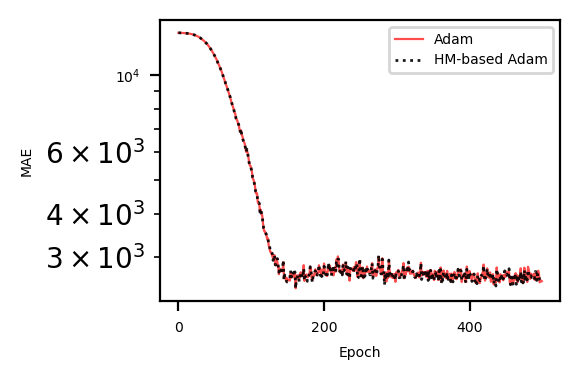

In [195]:
x1 = range(0, df1.shape[0])
x2 = range(0, df2.shape[0])
y1 = df1['mae'] 
y2 = df2['mae']  
plt.figure(figsize = (3,2), dpi = 200)
plt.plot(x1, y1, "r-", label = opti_name, linewidth = 0.8, alpha = 0.7)
plt.plot(x2, y2, "k:", label = 'HM-based ' + opti_name, linewidth = 1, alpha = 0.9) 
plt.ylabel('MAE' , fontdict = {'fontsize':5})
plt.xlabel('Epoch', fontdict = {'fontsize':5})
plt.xlabel('Epoch', fontdict = {'fontsize':5}) 
plt.yscale('log')
#plt.title("MAE", fontdict = {'fontname':'Times New Roman', 'fontsize':8})
plt.xticks(fontsize = 5)
plt.yticks(fontsize = 5)
plt.tight_layout()
plt.legend(prop={'size': 5})
#plt.savefig("graph.png",bbox_inches='tight',dpi=(300)) 
plt.show()

#### Testing the model

Generic opimizer model

In [192]:
generic_testing = model_wihtout_hm.evaluate(X_test, y_test)
generic_testing  

9/9 [==============================] - 0s 2ms/step - loss: 20090064.0000 - mae: 2621.2515


[20090064.0, 2621.25146484375]

HM based optimizer model

In [193]:
hm_testing = model_hm.evaluate(X_test, y_test)
hm_testing

9/9 [==============================] - 0s 3ms/step - loss: 20116226.0000 - mae: 2584.9541


[20116226.0, 2584.9541015625]

<h2 style="color:blue" align="center">Training Loss vs Validation Loss</h2>

For generic optimizer

In [152]:
model_wihtout_hm_val = get_model()
model_wihtout_hm_val.set_weights(weights) 
history = model_wihtout_hm_val.fit(X_train, y_train, epochs = num_epochs, verbose=0, validation_split=0.2, batch_size=batch_size) 

In [153]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

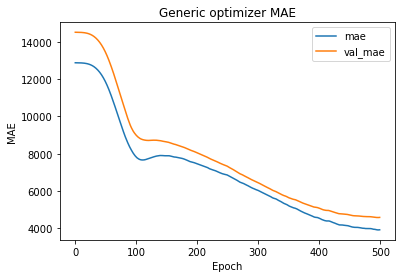

In [154]:
plt.figure(figsize=(6,4))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Generic optimizer MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['mae', 'val_mae'], loc='upper right')
plt.show()

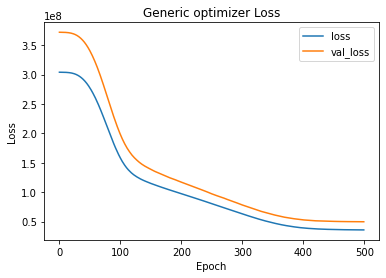

In [155]:
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Generic optimizer Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

For HM-based optimizer

In [156]:
model_wiht_hm_val = get_model()
model_wiht_hm_val.set_weights(weights) 
history_hm = model_wiht_hm_val.fit(X_train, y_train, epochs = num_epochs, verbose=0, validation_split=0.2, callbacks=[CustomCallbackHM()], batch_size=batch_size) 

In [157]:
history_hm.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

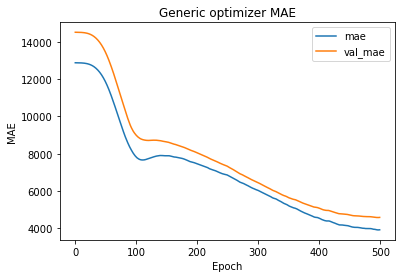

In [158]:
plt.figure(figsize=(6,4))
plt.plot(history_hm.history['mae'])
plt.plot(history_hm.history['val_mae'])
plt.title('Generic optimizer MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['mae', 'val_mae'], loc='upper right')
plt.show()

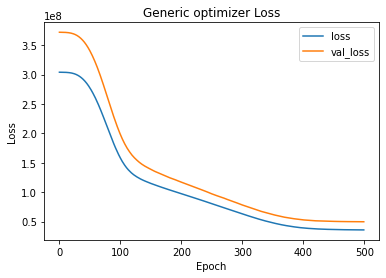

In [159]:
plt.figure(figsize=(6,4))
plt.plot(history_hm.history['loss'])
plt.plot(history_hm.history['val_loss'])
plt.title('Generic optimizer Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()

<h2 style="color:blue" align="center">Cross Validation</h2>

In [162]:
num_folds = 5 
# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits = num_folds, shuffle = False)

# Define per-fold score containers  
mae_per_fold = []
loss_per_fold = []

mae_per_fold_hm = []
loss_per_fold_hm = [] 
 
# K-fold Cross Validation model evaluation
fold_no = 1

model = get_model() 
weights = model.get_weights() 

for train, test in kfold.split(inputs, targets):    
    model_wihtout_hm = get_model()
    model_wihtout_hm.set_weights(weights) 
    model_wihtout_hm.fit(inputs[train], targets[train], epochs = num_epochs, verbose = 0, batch_size = batch_size) 
    scores = model_wihtout_hm.evaluate(inputs[test], targets[test], verbose = 0)
    #print(f'Score for fold {fold_no}: {model_wihtout_hm.metrics_names[0]} of {scores[0]}; {model_wihtout_hm.metrics_names[1]} of {scores[1]}') 
    mae_per_fold.append(scores[1]) 
    loss_per_fold.append(scores[0])
    
    model_hm = get_model() 
    model_hm.set_weights(weights) 
    model_hm.fit(inputs[train], targets[train], epochs = num_epochs, verbose = 0, callbacks=[CustomCallbackHM()], batch_size = batch_size) 
    scores_hm = model_hm.evaluate(inputs[test], targets[test], verbose = 0)
    #print(f'Score for fold {fold_no}: {model_hm.metrics_names[0]} of {scores_hm[0]}; {model_hm.metrics_names[1]} of {scores_hm[1]}') 
    mae_per_fold_hm.append(scores_hm[1]) 
    loss_per_fold_hm.append(scores_hm[0])
    
    fold_no = fold_no + 1 

In [163]:
# == Provide average scores ==
print('-------------------------------------------')
print('Score per fold for model without HM')
for i in range(0, num_folds):
  print('-------------------------------------------')
  print(f'> Fold {i+1} - Loss: {round(loss_per_fold[i],3)} - MAE: {round(mae_per_fold[i],3)}')
print('-------------------------------------------')
print('Average scores for all folds:')
print(f'> MAE: {round(np.mean(mae_per_fold),3)} (+- {round(np.std(mae_per_fold),3)})')
print(f'> Loss: {round(np.mean(loss_per_fold),3)}')
print('-------------------------------------------')
print('Score per fold for model with HM')
for i in range(0, num_folds):
  print('-------------------------------------------')
  print(f'> Fold {i+1} - Loss: {round(loss_per_fold_hm[i],3)} - MAE: {round(mae_per_fold_hm[i],3)}')
print('-------------------------------------------')
print('Average scores for all folds:')
print(f'> MAE: {round(np.mean(mae_per_fold_hm),3)} (+- {round(np.std(mae_per_fold_hm),3)})')
print(f'> Loss: {round(np.mean(loss_per_fold_hm),3)}')
print('-------------------------------------------')

-------------------------------------------
Score per fold for model without HM
-------------------------------------------
> Fold 1 - Loss: 32969010.0 - MAE: 3914.192
-------------------------------------------
> Fold 2 - Loss: 38357960.0 - MAE: 3955.842
-------------------------------------------
> Fold 3 - Loss: 37082880.0 - MAE: 4106.708
-------------------------------------------
> Fold 4 - Loss: 45469748.0 - MAE: 4413.493
-------------------------------------------
> Fold 5 - Loss: 32021940.0 - MAE: 3836.751
-------------------------------------------
Average scores for all folds:
> MAE: 4045.397 (+- 203.971)
> Loss: 37180307.6
-------------------------------------------
Score per fold for model with HM
-------------------------------------------
> Fold 1 - Loss: 32612714.0 - MAE: 3916.492
-------------------------------------------
> Fold 2 - Loss: 37829488.0 - MAE: 3953.166
-------------------------------------------
> Fold 3 - Loss: 36675564.0 - MAE: 4105.65
------------------

#### Release the GPU memory